# Como executar

Para executar esse notebook com CPU ou GPU siga os passos abaixo:
1. Baixe este notebook e importe para o <a href="https://colab.google/">Google Colab</a> ou acesse o link: https://colab.research.google.com/drive/1co1FJ1T7dXziRNtWJv-g1hoeUTNg31vt?usp=sharing
2. No menu superior direito do colab, onde está escrito "Conectar" ou "Ligar", clique na seta ao lado e escolha a opção "Alterar o tipo de ambiente de execução"
3. Uma janela será aberta onde você pode escolher entre utilizar CPU ou GPU. Escolha a que deseja utilizar (caso esteja em uma conta gratuita, apenas CPU e a T4 GPU estarão disponíveis). Clique em "OK" caso um pop-up apareça. Dica: GPUs são mais rápidas.
4. Para rodar este notebook, alguns arquivos são necessários. Acesse https://drive.google.com/drive/folders/1vcymtzjDJqVRd3x0ivSywnouhkqotq5J?usp=sharing e baixe os quatro arquivos da pasta. Caso prefira, poderá salvá-los em seu Google Drive, criando uma cópia. Esses são os dados que serão utilizados no modelo ("X" e "Y" são os dados prontos e são suficientes caso deseje ir diretamente para o treinamento, pulando a etapa "Preparação final dos Dados". "imgs" e "masks" são os dados pré-processados, mas ainda não passados pela última etapa).

Caso tenha baixado localmente:
5. Aguarde o download dos arquivos. Após, no menu lateral esquerdo do colab clique no ícone de pasta (último ícone), e depois no primeiro ícone para upload de arquivos ("Fazer upload para o armazenamento da sessão").
6. Adicione os dois arquivos previamente baixados.

Pronto! Já está tudo preparado para execução.

<strong>OBS: Caso deseje alterar de CPU para GPU, ou vice-versa, durante a execução, a sessão será reiniciada e tudo deverá ser executado novamente.

In [1]:
!pip install psutil


Gerenciamento de dependências:
- Utilizamos um arquivo requirements.txt para listar todas as bibliotecas e dependências necessárias para o projeto, garantindo que todos os colaboradores usem as mesmas versões. Abaixo está a importação delas.

Configurações e variáveis de ambiente:
- Não tivemos nenhum código que envolva este tópico

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle
import pandas as pd
import tensorflow as tf
from keras import Input
from keras.utils import Sequence, get_custom_objects
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from keras.models import Model, load_model
from keras import backend as K

from sklearn.model_selection import train_test_split
import time
import psutil
from tabulate import tabulate
from typing import Dict, Union, List

In [3]:
!pip freeze

absl-py==1.4.0
aiohttp==3.9.5
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.15.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.6.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.2
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.1
cryptography==42.0.7
cuda-python==12.2.1
cudf-cu12 @ https://pypi.nvidia.c

In [4]:
# caso tenha os arquivos em seu drive execute esta célula
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# U-NET

A U-Net é uma arquitetura para a segmentação semântica. É constituída por um caminho de contração e um caminho de expansão. O caminho de contração segue a arquitetura típica de uma rede convolucional. Consiste na aplicação repetida de duas convoluções 3x3, cada uma seguida de uma ReLU e de uma operação de max pooling 2x2 para a redução da dimensão. Em cada passo de redução, duplicamos o número de filtros. Cada passo na via expansiva consiste num upscaling do mapa de características seguida de uma convolução 2x2 ("up-convolution") que reduz para metade o número de filtros, uma concatenação com o mapa de características recortado correspondente da via de contração e duas convoluções 3x3, cada uma seguida de uma ReLU. O recorte é necessário devido à perda de pixéis da borda em cada convolução. Na camada final, é utilizada uma convolução 1x1 para mapear cada vetor de características de 64 componentes para o número desejado de classes.

Referências:
- https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406
- RONNEBERGER, Olaf; FISCHER, Philipp; BROX, Thomas. U-net: Convolutional networks for biomedical image segmentation. In: **Medical image computing and computer-assisted intervention–MICCAI 2015: 18th international conference, Munich, Germany, October 5-9, 2015, proceedings, part III 18**. Springer International Publishing, 2015. p. 234-241.

## Classe do modelo

Encapsulamento:
- A classe GeradorSequencias encapsula a lógica de geração de lotes (batches) de dados. Isso ajuda a manter a lógica organizada e modular.

Documentação completa:
- A classe e seus métodos estão devidamente documentadas utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - A classe está organizada de forma modular, permitindo que seja facilmente testada e mantida.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- A classe GeradorSequencias contém métodos que podem ser reutilizados em diferentes partes do código, como __len__ e __getitem__. O uso de parâmetros torna-as mais dinâmicas.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging.

In [5]:
class GeradorSequencias(Sequence):
  """
  Inicializa o gerador de sequências com as entradas, saídas e o tamanho do lote.

  Args:
  entradas (array): Dados de entrada.
  saidas (array): Dados de saída correspondentes.
  batch_size (int): Tamanho do lote.
  """
  def __init__(self, entradas, saidas, batch_size):
    self.entradas = entradas
    self.saidas = saidas
    self.batch_size = batch_size

  def __len__(self): #quantidade de lotes
    return len(self.entradas) // self.batch_size

  def __getitem__(self, id):
    """
    Retorna um batch com dados de entrada e saída

    Args:
      id (int): índice do batch que se deseja
    Returns:
      x (np.array): imagens dos satélites
      y (np.array): máscaras das imagens
    """
    try:
      esquerda = id * self.batch_size
      direita = min(esquerda + self.batch_size, len(self.entradas))
      batch_entradas = self.entradas[esquerda:direita]
      batch_saidas = self.saidas[esquerda:direita]

      x = np.array([img for img in batch_entradas], dtype=np.float32)
      y = np.array([img for img in batch_saidas], dtype=np.float32)

      return x, y
    except Exception as e:
        print(f"Erro ao obter o batch: {e}")
        raise

Encapsulamento:
- A classe UNet encapsula a lógica de construção, treinamento e visualização de uma rede neural UNet.

Documentação completa:
- A classe e seus métodos estão devidamente documentadas utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - A classe está organizada de forma modular, permitindo que cada bloco funcional (codificador, decodificador, treinamento, visualização) seja facilmente mantido e atualizado.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- As funções enconder_mini_block e decoder_mini_block são exemplos de código reutilizável dentro da arquitetura UNet, permitindo a fácil modificação da estrutura da rede. As funções de treinamento (train_model) e visualização de resultados (plot_results) são projetadas para serem reutilizáveis em diferentes contextos de experimentação.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [7]:
class UNet():
  def __init__(self, input_size, X, Y, n_filters=32, n_classes=1):
    """
    Inicializa a classe UNet

    Args:
    input_size: tuple, tamanho da imagem de entrada
    X: numpy array, imagens de entrada
    Y: numpy array, máscaras representando as classes
    n_filters: int, número de filtros iniciais
    n_classes: int, número de classes
    """
    self.input_size = input_size
    self.n_filters = n_filters
    self.n_classes = n_classes
    self.x = X
    self.y = Y

  def encoder_mini_block(self, inputs, n_filters, dropout=False):
    """
    Cria o caminho de contração da UNet

    Args:
      input: tuple, tamanho da imagem de entrada
      n_filters: int, número de filtros iniciais
      max_pooling: bool, se True aplica max pooling, se False não aplica

    Returns:
      pool: tensor, camada de pooling
      skip_connection: tensor, camada de conexão
    """
    c = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    c = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c)
    c = BatchNormalization()(c)
    p = MaxPooling2D((2, 2))(c)
    if dropout:
        c = Dropout(0.3)(c)
    return c, p

  def decoder_mini_block(self, inputs, conv_output, n_filters):
    """
      Cria o caminho de expansão da UNet

      Args:
        prev_layer_input: tensor, camada de entrada
        skip_layer_input: tensor, camada de conexão
        n_filters: int, número de filtros iniciais

      Returns:
        conv: tensor, camada de convolução
    """
    us = Conv2DTranspose(n_filters, 3, strides=(2, 2), padding='same')(inputs)
    us = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(us)
    concat = concatenate([us, conv_output], axis=3)
    c = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat)
    c = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c)
    return c

  def unet_compiled(self):
    try:
      inputs = Input(self.input_size)

      cblock1, pblock1 = self.encoder_mini_block(inputs, self.n_filters, True)
      cblock2, pblock2 = self.encoder_mini_block(pblock1, self.n_filters * 2, True)
      cblock3, pblock3 = self.encoder_mini_block(pblock2, self.n_filters * 4, True)
      cblock4, pblock4 = self.encoder_mini_block(pblock3, self.n_filters * 8, False)
      bottleneck, _ = self.encoder_mini_block(pblock4, self.n_filters * 16, False)

      ublock5 = self.decoder_mini_block(bottleneck, cblock4, self.n_filters * 8)
      ublock6 = self.decoder_mini_block(ublock5, cblock3, self.n_filters * 4)
      ublock7 = self.decoder_mini_block(ublock6, cblock2, self.n_filters * 2)
      ublock8 = self.decoder_mini_block(ublock7, cblock1, self.n_filters)

      conv9 = Conv2D(self.n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock8)
      conv10 = Conv2D(self.n_classes, 1, activation='sigmoid')(conv9)

      model = Model(inputs=inputs, outputs=conv10)

      self.model = model
    except Exception as e:
      print(f"Erro ao criar o modelo: {e}")
      raise


  def train_model(self, gerador=None):
    try:
      self.unet_compiled()

      callbacks = [
          tf.keras.callbacks.EarlyStopping(
              monitor='val_accuracy',
              min_delta=0.005,
              patience=5,
              verbose=1,
              restore_best_weights=True,
              start_from_epoch=5),
      ]

      X_train, X_test, y_train, y_test = train_test_split(self.x, self.y, test_size=0.3)

      self.model.summary()

      self.model.compile(optimizer=tf.keras.optimizers.Adam(),
                          loss=tanimoto_loss,
                          metrics=['accuracy'])

      results = self.model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=callbacks)
      return results
    except Exception as e:
      print(f"Erro ao treinar o modelo: {e}")
      raise

  def plot_results(self, results):
    """
      Plota os resultados do treinamento - Precisão e Perda dos conjuntos de Treino e Validação

      Args:
        results: dict, resultados do treinamento
    """
    try:
      acc = results.history['accuracy']
      val_acc = results.history['val_accuracy']
      loss = results.history['loss']
      val_loss = results.history['val_loss']
      epochs = range(len(acc))
      plt.plot(epochs, acc, 'g', label='Acurácia do conjunto de Treino')
      plt.plot(epochs, val_acc, 'b', label='Acurácia do conjunto de Validação')
      plt.plot(epochs, loss, 'r', label='Perda do conjunto de Treino')
      plt.plot(epochs, val_loss, 'm', label='Perda do conjunto de Validação')
      plt.title('Acurácia dos conjuntos de Treino e Validação')
      plt.xlabel('Épocas')
      plt.ylabel('Acurácia/Perda')
      plt.legend(loc=0)
      plt.figure()
      plt.show()
    except Exception as e:
      print(f"Erro ao criar o gráfico: {e}")
      raise

# Função de perda customizada (Tanimoto Loss)
# Essa função foi adaptada da página 99 do paper "ResUNet-a: A deep learning framework for semantic
# segmentation of remotely sensed data" de DIAKOGIANNIS et al. (2020)
def tanimoto_loss(y_true, y_pred):
  y_true = K.cast(y_true, y_pred.dtype)

  rdc = range(1, K.ndim(y_pred))
  a = K.sum(y_true * y_pred, axis=rdc)
  b = K.sum(y_true**2 + y_pred**2 - y_true * y_pred, axis=rdc)
  return 1 - a / b


## Leitura e Preparação dos Dados
Caso tenha subido os arquivos diretamente no colab, clique nos três pontos que aparecem ao passar o cursor em cima do arquivo e selecione "Copiar caminho". No caso do Drive, busque os arquivos na pasta "drive" e faça o mesmo procedimento descrito anteriormente. Substitua os caminhos das células abaixo conforme necessário.

<strong> OBS: Atente-se aos arquivos que estão sendo chamados

### Preparação final dos dados
As células abaixo redimensionam as imagens nos shapes desejados e salva em um pickle os dados divididos em imagens (X) e rótulos (Y).

<strong>OBS: Caso os arquivos pickle (.pkl) já estejam salvos não é necessário rodá-las. Sempre que essa célula é executada, os arquivos são sobrescritos.

Encapsulamento:
- A função load_data encapsula a lógica de carregamento e processamento de dados de imagens e máscaras, mantendo o código modular e reutilizável.

Documentação completa:
- A função está evidamente documentada utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - A função está organizada de forma modular, permitindo que a lógica de carregamento de dados seja facilmente mantida e atualizada.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- A função load_data é projetada para ser reutilizável em diferentes contextos de pré-processamento de dados, podendo aceitar diferentes dataframes por meio de parâmetros.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

### Leitura dos dados

In [8]:
file_x = open('/content/drive/MyDrive/Satelite Data/loaded_df/X_backup.pkl', 'rb')

X = pickle.load(file_x)

file_y = open('/content/drive/MyDrive/Satelite Data/loaded_df/Y_backup.pkl', 'rb')

Y = pickle.load(file_y)

file_x.close()
file_y.close()


Encapsulamento:
- A função memory_usage_psutil encapsula a lógica de obtenção do uso de memória de um processo, permitindo reutilização e modularidade.

Documentação completa:
- A função está evidamente documentada utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - A função é independente e pode ser facilmente integrada em outros módulos ou scripts.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- A função memory_usage_psutil pode ser reutilizada em diferentes partes do código onde o monitoramento do uso de memória é necessário. Esta função é projetada para ser chamada sempre que for necessário verificar o uso de memória do processo atual.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [9]:
def memory_usage_psutil():
    """
        Retorna a quantidade de memória utilizada pelo processo em MB
    """
    try:
      process = psutil.Process()
      mem = process.memory_info().rss / float(2 ** 20)  # em MB
      return mem
    except Exception as e:
        print(f"Erro ao calcular a memória: {e}")
        raise

### Gerador de Batch

Encapsulamento:
- A função compare_batches encapsula a lógica de comparação de lotes de dados gerados com os dados originais, mantendo o código modular e reutilizável.

Documentação completa:
- A função está evidamente documentada utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - A função está organizada de forma modular, permitindo que a lógica de comparação de lotes seja facilmente mantida e atualizada.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- A função compare_batches pode ser reutilizada para verificar a consistência de dados em diferentes partes do código onde o gerador de lotes é utilizado. É projetada para ser chamada sempre que for necessário validar a correção dos lotes gerados pelo gerador de sequências.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [10]:
# Função para comparar lotes de dados
def compare_batches(X, y, gerador, num_batches=10):
    """
    Compara os batchs gerados com os dados originais

    Args:
      X (np.array): dados de imagem originais
      y (np.array): máscaras originais
      num_batches (int): número de batches gerados
    """
    try:
      for i in range(num_batches):
          x_batch, y_batch = gerador[i]
          print(f"Batch {i}:")
          print(f"x_batch shape: {x_batch.shape}, y_batch shape: {y_batch.shape}")
          # Compare o conteúdo de x_batch e y_batch com os dados originais
          if not np.array_equal(x_batch, X[i * gerador.batch_size : (i + 1) * gerador.batch_size]):
              print("Diferença encontrada nos dados de entrada!")
          if not np.array_equal(y_batch, y[i * gerador.batch_size : (i + 1) * gerador.batch_size]):
              print("Diferença encontrada nos dados de saída!")
    except Exception as e:
        print(f"Não foi possível fazer a comparação: {e}")
        raise

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# Criação do gerador
gerador = GeradorSequencias(X_train, y_train, 32)

# Comparação dos lotes gerados com os dados originais
compare_batches(X_train, y_train, gerador)

Batch 0:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 1:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 2:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 3:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 4:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 5:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 6:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 7:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 8:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)
Batch 9:
x_batch shape: (32, 208, 208, 3), y_batch shape: (32, 208, 208, 1)


## Execução do treinamento e predição em diferentes ambientes de execução
Execute as células apenas referentes ao ambiente escolhido anteriormente.

### Métricas de avaliação

Encapsulamento:
- As funções get_confusion_matrix, get_binary_confusion_matrix e extract_binary_confusion_matrix encapsulam a lógica para calcular matrizes de confusão de categorias múltiplas e binárias, mantendo o código modular e reutilizável.

Documentação completa:
- A função está evidamente documentada utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - Cada função é modular e pode ser usada de forma independente para calcular matrizes de confusão, seja para categorias múltiplas ou para casos binários.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- As funções get_confusion_matrix, get_binary_confusion_matrix e extract_binary_confusion_matrix são projetadas para serem reutilizáveis em diferentes contextos de avaliação de modelos, fornecendo uma maneira eficiente de calcular e extrair matrizes de confusão.

Manuseio de erros:
 - Caso haja um erro na execução (validado pelo assert), uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [11]:
def get_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray,
        n_categories: int) -> np.ndarray:
    '''
    Gets confusion matrix from predictions.

    Parameters:
    - y_true: true labels with shape (n_examples, ).
    - y_pred: predicted labels with shape (n_examples, ).
    - n_categories: the number of categories.

    Returns:
    n_categories x n_categories ndarray representing confusion matrix.
    '''
    assert y_true.shape == y_pred.shape
    assert y_true.ndim == 1

    mtx = np.zeros(shape=(n_categories, n_categories), dtype='uint64')

    for i in range(n_categories):
        category_i = (y_true == i)
        for j in range(n_categories):
            category_j = (y_pred == j)
            mtx[i, j] = (category_i & category_j).sum()

    return mtx


def get_binary_confusion_matrix(
        y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    '''
    Gets binary confusion matrix from hard predictions.

    Parameters:
    - y_true: Ground-truth with shape (n_examples, ).
      Assumes 1 is for positive and 0 for negative.
    - y_pred: Predictions with shape (n_examples, ).
      Assumes 1 is for positive and 0 for negative.

    Returns:
    2x2 binary confusion matrix (using index 0 for positive category).
    '''
    y_true = y_true.astype('uint8')
    y_pred = y_pred.astype('uint8')
    weights = np.ones(shape=y_true.shape, dtype='float32')

    tp = int(((y_true & y_pred)*weights).sum())
    tn = int((((y_true^1) & (y_pred^1))*weights).sum())
    fp = int((((y_true^1) & y_pred)*weights).sum())
    fn = int(((y_true & (y_pred^1))*weights).sum())

    return np.array([[tp, fn], [fp, tn]], dtype='uint64')


def extract_binary_confusion_matrix(
        conf_mtx: np.ndarray, category: int) -> np.ndarray:
    '''
    From (possibly) multi-class confusion matrix, and
    index of positive category, computes binary
    confusion matrix (using index 0 for positive category).

    Parameters:
    - conf_mtx: square ndarray representing the confusion matrix.
    - category: index of category to be considered positive category.

    Returns:
    2x2 binary confusion matrix (using index 0 for positive category).
    '''
    assert category < conf_mtx.shape[0]
    summ_col = conf_mtx[:, category].sum()
    summ_row = conf_mtx[category].sum()
    summ = conf_mtx.sum()
    tp = conf_mtx[category, category]
    tn = summ - (summ_col + summ_row - tp)
    fp = summ_col - tp
    fn = summ_row - tp
    return np.array([
        [tp, fn],
        [fp, tn]], dtype='uint64')

Encapsulamento:
- A classe ClassificationMetrics encapsula a lógica de cálculo e manipulação de métricas de classificação, mantendo o código modular e reutilizável.

Documentação completa:
- A classe e seus métodos estão devidamente documentadas utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - Cada método da classe é modular e pode ser usado de forma independente para calcular e manipular métricas de classificação.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- A classe ClassificationMetrics e seus métodos são projetados para serem reutilizáveis em diferentes contextos de avaliação de modelos, fornecendo uma maneira eficiente de calcular e manipular métricas de classificação.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [12]:
class ClassificationMetrics:
    '''
    Metrics for multi-class predictor classification.
    '''

    @classmethod
    def from_decisions(cls, y_true: np.ndarray, y_pred: np.ndarray,
            n_categories: int) -> 'ClassificationMetrics':
        '''
        Instantiates object from hard predictions.
        '''
        mtx = get_confusion_matrix(y_true, y_pred, n_categories=n_categories)
        return cls(mtx)

    @classmethod
    def from_confusion_matrix(cls, conf_mtx: np.ndarray) \
            -> 'ClassificationMetrics':
        '''
        Instantiates object from confusion matrix.
        '''
        return cls(np.array(conf_mtx))

    def __init__(self, conf_mtx: np.ndarray):
        self._conf_mtx = conf_mtx
        self._n_categories = conf_mtx.shape[0]

    @property
    def conf_mtx(self) -> np.ndarray:
        '''
        The confusion matrix of the evaluation.
        '''
        return self._conf_mtx

    @property
    def n_categories(self) -> int:
        '''
        The number of categories of the evaluated classifiers.
        '''
        return self._n_categories

    @property
    def accuracy(self) -> float:
        '''
        The accuracy of the classifier.
        '''
        summ = self._conf_mtx.sum()
        return 0. if summ == 0 else float(self._conf_mtx.diagonal().sum()/summ)

    def as_json_dict(self) -> Dict[str, Union[int, float]]:
        '''
        The metrics of the classifiers as a jsonifiable dictionary.
        '''
        data = {
            'accuracy': self.accuracy,
        }
        return data

    def for_category(self, category: int) -> 'BinaryClassificationMetrics':
        '''
        Gets a BinaryClassificationMetrics instance for chosen category.
        '''
        if category >= self._n_categories:
            raise ValueError(
                f'there are only {self._n_categories} classes (<= {category})')
        return BinaryClassificationMetrics(
            extract_binary_confusion_matrix(self._conf_mtx, category))

    def split(self) -> List['BinaryClassificationMetrics']:
        '''
        Splits the evaluation into n_categories BinaryClassificationMetrics
        objects.
        '''
        return [self.for_category(i) for i in range(self.n_categories)]

In [13]:
'''
Module for covr metric.
'''

from collections import namedtuple
from typing import List
from skimage import measure as meas


Labeling = namedtuple('Labeling', [
    'img',
    'props',
])


Isection = namedtuple('Isection', [
    'yt_label',
    'yp_label',
    'prop',
])


IntersectionGroup = namedtuple('IntersectionGroup', [
    'yt_lab',
    'yp_lab',
    'isect_lab',
    'isections',
])

CoverageResult = namedtuple('CoverageResult', [
    'n_labels',
    'n_cov_labels',
])


IsectionProps = namedtuple('IsectionProps', [
    'yt_label',
    'yt_area',
    'yp_label',
    'yp_area',
    'isect_label',
    'isect_area',
])


def _label(mask):
    labels_img = meas.label(mask, connectivity=2,
                            background=0, return_num=False)
    props = meas.regionprops(labels_img, cache=True)
    props = {p.label: p for p in props}
    return Labeling(labels_img, props)


def _get_isection_group(yt, yp):
    yt_lab = _label(yt)
    yp_lab = _label(yp)
    isect = yt & yp
    isect_lab = _label(isect)

    elems = []
    for prop in isect_lab.props.values():
        i, j = next(iter(prop.coords))
        elems.append(Isection(
            yt_label=yt_lab.img[i, j],
            yp_label=yp_lab.img[i, j],
            prop=prop))

    return IntersectionGroup(
        yt_lab=yt_lab,
        yp_lab=yp_lab,
        isect_lab=isect_lab,
        isections=elems)


def _get_isection_props(isect_group):
    properties = []
    for isect in isect_group.isections:
        properties.append(IsectionProps(
            yt_label=isect.yt_label,
            yt_area=isect_group.yt_lab.props[isect.yt_label].area,
            yp_label=isect.yp_label,
            yp_area=isect_group.yp_lab.props[isect.yp_label].area,
            isect_label=isect.prop.label,
            isect_area=isect.prop.area
        ))
    return properties


def _get_nearest_yp(isection_props):
    matches = {}
    for prop in isection_props:
        key = prop.yp_label
        if key not in matches or prop.isect_area > matches[key].isect_area:
            matches[key] = prop
    return matches


def _get_coverage(isection_props, min_yt_frac=0.1, min_yp_frac=0.5):
    coverage = []
    cands = _get_nearest_yp(isection_props)

    for prop in cands.values():
        yt_frac = prop.isect_area/max(prop.yt_area, 1)
        if yt_frac < min_yt_frac:
            continue
        yp_frac = prop.isect_area/max(prop.yp_area, 1)
        if yp_frac < min_yp_frac:
            continue
        coverage.append(prop)

    return coverage


def _get_coverage_numbers(yt, yp):
    isect_group = _get_isection_group(yt, yp)
    isect_props = _get_isection_props(isect_group)
    coverage = _get_coverage(isect_props)

    n_yt_labels = len(isect_group.yt_lab.props)
    n_cov_yt_labels = len({p.yt_label for p in coverage})

    return CoverageResult(
        n_labels=n_yt_labels,
        n_cov_labels=n_cov_yt_labels)


class CoverageMetric(ClassificationMetrics):
    '''
    Coverage Metric for multi-class predictor classification.
    '''

    @classmethod
    def get_coverage_ratio(cls, yts: List[np.ndarray],
                           yps: List[np.ndarray], thr: str = 0.5) -> float:
        """
        Get coverage ratio metric based on ground truth and predictions.

        Args:
            yts: Ground truths
            yps: predictions
            thr: Threshold to convert predictions to mask. Defaults to 0.5

        Returns:
            Coverage ratio metric for ground truth and predictions.
        """
        n_labels = 0
        n_cov_labels = 0

        for yt, yp in zip(yts, yps):
            yp = (yp >= thr).astype('uint8')
            cov = _get_coverage_numbers(yt, yp)
            n_labels += cov.n_labels
            n_cov_labels += cov.n_cov_labels

        ratio = n_cov_labels/max(n_labels, 1)
        return ratio

Encapsulamento:
- A classe BinaryClassificationMetrics encapsula a lógica de cálculo e manipulação de métricas de classificação para problemas de classificação binários, mantendo o código modular e reutilizável.

Documentação completa:
- A classe e seus métodos estão devidamente documentadas utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - Cada método da classe é modular e pode ser usado de forma independente para calcular e manipular métricas de classificação.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- A classe BinaryClassificationMetrics e seus métodos são projetados para serem reutilizáveis em diferentes contextos de avaliação de modelos, fornecendo uma maneira eficiente de calcular e manipular métricas de classificação.

Manuseio de erros:
 - Caso haja um erro na execução (por meio do assert), uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [14]:
class BinaryClassificationMetrics(ClassificationMetrics):
    '''
    Metrics for binary predictor classification.
    '''

    # pylint: disable=arguments-differ
    @classmethod
    def from_decisions(cls, y_true: np.ndarray, y_pred: np.ndarray) \
            -> 'BinaryClassificationMetrics':
        '''
        Initializes class from true and predicted hard labels.

        Parameters:
        - y_true: Ground-truth with shape (n_examples, ).
          Assumes 1 is for positive and 0 for negative.
        - y_pred: Predictions with shape (n_examples, ).
          Assumes 1 is for positive and 0 for negative.
        '''
        assert y_true.ndim == 1
        assert y_pred.ndim == 1
        return BinaryClassificationMetrics(
            get_binary_confusion_matrix(y_true, y_pred))

    def __init__(self, conf_mtx: np.ndarray):
        super().__init__(conf_mtx)
        assert self._n_categories == 2

    @property
    def tp(self) -> int:
        '''
        Number of positives classified as positives.
        '''
        return int(self._conf_mtx[0, 0])

    @property
    def tn(self) -> int:
        '''
        Number of negatives classified as negatives.
        '''
        return int(self._conf_mtx[1, 1])

    @property
    def fp(self) -> int:
        '''
        Number of negatives classified as positives.
        '''
        return int(self._conf_mtx[1, 0])

    @property
    def fn(self) -> int:
        '''
        Number of positives classified as negatives.
        '''
        return int(self._conf_mtx[0, 1])

    @property
    def n_pos(self) -> int:
        '''
        Number of positives.
        '''
        return self.tp + self.fn

    @property
    def n_neg(self) -> int:
        '''
        Number of negatives.
        '''
        return self.tn + self.fp

    @property
    def tpr(self) -> float:
        '''
        True positive rate.
        '''
        return 0. if self.n_pos < 1 else self.tp/self.n_pos

    @property
    def tnr(self) -> float:
        '''
        True negative rate.
        '''
        return 0. if self.n_neg < 1 else self.tn/self.n_neg

    @property
    def fpr(self) -> float:
        '''
        False positive rate.
        '''
        return 1 - self.tnr

    @property
    def fnr(self) -> float:
        '''
        False negative rate.
        '''
        return 1 - self.tpr

    @property
    def precision(self) -> float:
        '''
        Precision.
        '''
        return 0. if (self.tp + self.fp < 1) else self.tp/(self.tp + self.fp)

    @property
    def recall(self) -> float:
        '''
        Recall.
        '''
        return self.tpr

    @property
    def f1_score(self) -> float:
        '''
        F1 score.
        '''
        summ = self.precision + self.recall
        return 0. if summ == 0 else 2*self.precision*self.recall/summ

    def fbeta_score(self, beta: float) -> float:
        '''
        F-beta score.
        '''
        summ = beta**2*self.precision + self.recall
        return 0. if summ == 0 else \
            (1 + beta**2)*self.precision*self.recall/summ

    @property
    def iou(self) -> float:
        '''
        Intersection Over Union.
        '''
        summ = self.tp + self.fp + self.fn
        return 0. if summ == 0 else self.tp/summ

    def as_json_dict(self) -> Dict[str, Union[int, float]]:
        '''
        Metrics as jsonifiable dictionary.
        '''
        data = super().as_json_dict()
        data.update({
            'tp': self.tp,
            'tn': self.tn,
            'fp': self.fp,
            'fn': self.fn,
            'n_pos': self.n_pos,
            'n_neg': self.n_neg,
            'tpr': self.tpr,
            'tnr': self.tnr,
            'fpr': self.fpr,
            'fnr': self.fnr,
            'iou': self.iou,
            'precision': self.precision,
            'recall': self.recall,
            'f1_score': self.f1_score,
        })
        return data

Encapsulamento:
- A função CalculateMetrics encapsula a lógica de cálculo de várias métricas de classificação para uma predição específica, mantendo o código modular e reutilizável.

Documentação completa:
- A função está evidamente documentada utilizando docstrings com descrições claras de parâmetros, retornos e funções, como pode ser visto nos comentários.

Modularidade:
 - A função CalculateMetrics é modular e pode ser usada de forma independente para calcular várias métricas de classificação.

Qualidade do código:
 - A qualidade do código foi garantida por meio de práticas como indentação consistente, nomes de variáveis significativos e comentários explicativos.

Funções e códigos reutilizáveis:
- A função CalculateMetrics e suas métricas são projetadas para serem reutilizáveis em diferentes contextos de avaliação de modelos, fornecendo uma maneira eficiente de calcular várias métricas de classificação.

Manuseio de erros:
 - Caso haja um erro na execução, uma exceção é lançada com uma mensagem resumindo o erro e o próprio erro para facilitar o debugging

In [15]:
def CalculateMetrics(y_true, y_pred, y_true_not_flat, y_pred_not_flat, n_classes=2):
  """
  Calcula várias métricas para uma predição do modelo

  Args:
    y_true(np.array): máscara verdadeira flat
    y_pred(np.array): máscara predita flat
    y_true_not_flat(208,208,1): máscara verdadeira
    y_pred_not_flat: (208,208,1): máscara predita

    n_classes(int): número de classes do modelo
  """
  try:
    cm = get_confusion_matrix(y_true, y_pred, 2)
    metricsClass = BinaryClassificationMetrics(cm)
    covrMetrics = CoverageMetric(cm).get_coverage_ratio(y_true_not_flat, y_pred_not_flat)
    accuracy = metricsClass.accuracy
    tp = metricsClass.tp
    tn = metricsClass.tn
    fp = metricsClass.fp
    fn = metricsClass.fn
    n_pos = metricsClass.n_pos
    n_neg = metricsClass.n_neg
    tpr = metricsClass.tpr
    tnr = metricsClass.tnr
    fpr = metricsClass.fpr
    fnr = metricsClass.fnr
    iou = metricsClass.iou
    precision = metricsClass.precision
    recall = metricsClass.recall
    f1_score = metricsClass.f1_score

    return tabulate([['Acurácia', accuracy], ['True Positives', tp], ['True Negatives', tn], ['False Positives', fp], ['False Negatives', fn], ['Number of Positives', n_pos], ['Number of Negatives', n_neg], ['True Positive Rate', tpr], ['True Negative Rate', tnr], ['False Positive Rate', fpr], ['False Negative Rate', fnr], ["IoU", iou], ["Precisão", precision], ["Recall", recall], ["F1 Score", f1_score], ["Coverage", covrMetrics]], headers=['Métrica', 'Valor'], tablefmt='orgtbl')
  except Exception as e:
        print(f"Erro ao calcular métricas: {e}")
        raise

### T4 GPU

#### Treinamento do modelo

In [47]:
unet = UNet((208, 208, 3), X, Y, n_filters=16)
unet.unet_compiled()
t4_time_train_start = time.time()
t4_mem_before = memory_usage_psutil()
results = unet.train_model()
t4_mem_after = memory_usage_psutil()
t4_mem_usage = t4_mem_after - t4_mem_before
t4_time_train_final = time.time() - t4_time_train_start

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 208, 208, 3)]        0         []                            
                                                                                                  
 conv2d_273 (Conv2D)         (None, 208, 208, 16)         448       ['input_13[0][0]']            
                                                                                                  
 conv2d_274 (Conv2D)         (None, 208, 208, 16)         2320      ['conv2d_273[0][0]']          
                                                                                                  
 batch_normalization_59 (Ba  (None, 208, 208, 16)         64        ['conv2d_274[0][0]']          
 tchNormalization)                                                                         

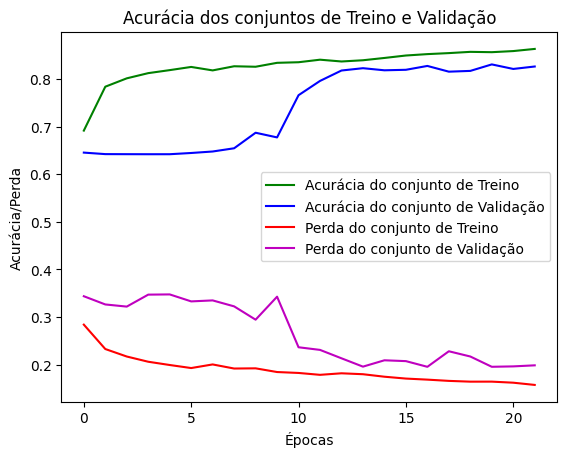

<Figure size 640x480 with 0 Axes>

In [48]:
unet.plot_results(results)

####Salvamento do modelo

In [49]:
unet.model.save("/content/drive/MyDrive/Models/UnetPropriaTanimoto.h5")

In [50]:
model_path = "/content/drive/MyDrive/Models/UnetPropriaTanimoto.h5"

get_custom_objects().update({"tanimoto_loss": tanimoto_loss})

saved_model = load_model(model_path, custom_objects={'tanimoto_loss': tanimoto_loss})


### A100 GPU

#### Treinamento do modelo

In [16]:
unet = UNet((208, 208, 3), X, Y, n_filters=16)
unet.unet_compiled()
a100_time_train_start = time.time()
a100_mem_before = memory_usage_psutil()
results = unet.train_model()
a100_mem_after = memory_usage_psutil()
a100_mem_usage = a100_mem_after - a100_mem_before
a100_time_train_final = time.time() - a100_time_train_start

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 208, 208, 3)]        0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 208, 208, 16)         448       ['input_2[0][0]']             
                                                                                                  
 conv2d_25 (Conv2D)          (None, 208, 208, 16)         2320      ['conv2d_24[0][0]']           
                                                                                                  
 batch_normalization_5 (Bat  (None, 208, 208, 16)         64        ['conv2d_25[0][0]']           
 chNormalization)                                                                           

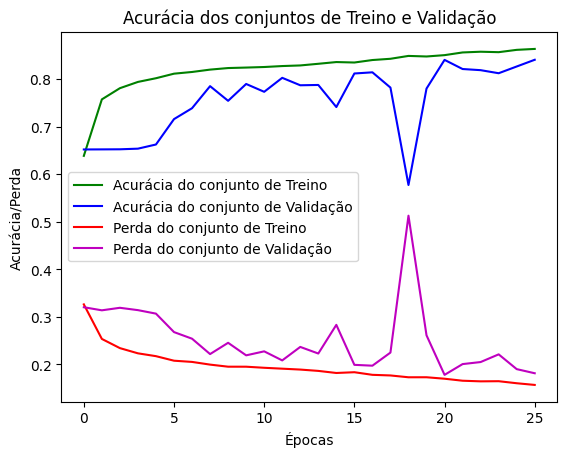

<Figure size 640x480 with 0 Axes>

In [17]:
unet.plot_results(results)

####Salvamento do modelo

In [18]:
unet.model.save("/content/drive/MyDrive/Models/UnetPropriaTanimoto.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
model_path = "/content/drive/MyDrive/Models/UnetPropriaTanimoto.h5"

get_custom_objects().update({"tanimoto_loss": tanimoto_loss})

saved_model = load_model(model_path, custom_objects={'tanimoto_loss': tanimoto_loss})

### Tempos de inferencia e treinamento
As células abaixo mostram o tempo de treinamento, predição e o uso de memória para cada tipo de ambiente de execução. É possível notar que a A100 GPU é consideravelmente mais eficiente que as outras.

#### T4 GPU

In [ ]:
print("Tempo de treinamento (em segundos) usando o T4 GPU: ", t4_time_train_final)
print("Tempo de inferência (em segundos) de 1 predição usando o T4 GPU: ", t4_inference_final)
print("Memória utilizada usando o A100 GPU: ", t4_mem_usage, "MB")

#### CPU

*O tempo de processamento da CPU apresentou uma demora relevante. Isso se deve ao fato da CPU ser executada de forma sequencial e a GPU de forma paralela.*

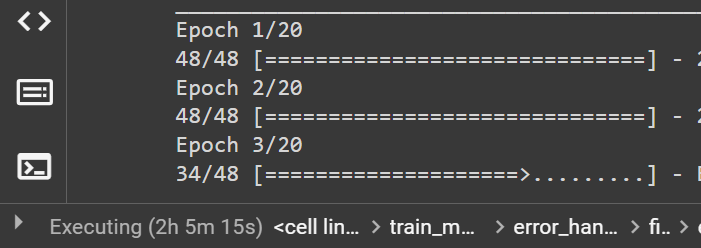

#### A100 GPU

In [22]:
print("Tempo de treinamento usando o A100 GPU: ", a100_time_train_final)
print("Tempo de inferência de 1 predição usando o A100 GPU: ", a100_inference_final)
print("Memória utilizada usando o A100 GPU: ", a100_mem_usage, "MB")

Tempo de treinamento usando o A100 GPU:  102.01713490486145
Tempo de inferência de 1 predição usando o A100 GPU:  1.0270826816558838
Memória utilizada usando o A100 GPU:  3376.9609375 MB
